# Step 3 - Generate Sentence Vectors

This script is to generate sentence vectors using fasttext pretrained model and run a simple test.

Prerequisites:
    To run this script, a fasttext pretrained model is needed. 
    Download link: https://fasttext.cc/docs/en/english-vectors.html
Input: 
    1. database file
    2. answer file
Output:
    1. Sentence embedding files in .npy with the same name as database file
    2. A json file (same name as the database file but with additional text '_results' in it) including all search results

In [1]:
%pylab inline
import os
import json
from PIL import Image
import utilities as util
import vectors

Populating the interactive namespace from numpy and matplotlib


c:\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [49]:
"""
Make sure these variables are correctly set.
model: file path to pretrained model
database_file: file path to database file generated from previous steps
answer_file: file path to answer file
moving_average_filter_enabled: whether or not to apply filter to sentence vectors. 
                               A separate numpy file will be generated with '_ma' in the file name
window_size: window size for the filter
"""

model = './fasttext/wiki.en' 
database_file = './data source/The Last Of Us/output/The_Last_Of_Us_top3keywords.json'
answer_file = './data source/The Last Of Us/output/correct_answers.json'
moving_average_filter_enabled = True
window_size = 5


In [3]:
%%time

word_embeddings = vectors.Vectors(model)
word_embeddings.load_word_vectors(mode='fasttext')

loading fasttext vectors
Wall time: 8min 3s


In [5]:
word_embeddings.vector_size

300

In [50]:
"""
get sentence vectors
"""

ind_dict = dict()
emb_dict_folder = os.path.dirname(database_file)
db_filename = os.path.splitext(os.path.basename(database_file))[0]
emb_dict_file = os.path.join(emb_dict_folder, db_filename + '_emb.json')
print(emb_dict_file)

sentence_vectors = np.empty((0, word_embeddings.vector_size))
sentence_vectors_filtered = np.empty((0, word_embeddings.vector_size))

with open(database_file, 'r') as input_file, \
    open(emb_dict_file, 'w') as output_file:
    json_str = input_file.read()
    database = json.loads(json_str)
    sentence_id = 0
    for file_idx, data in database.items():
        img_sessions = data['screenshots']['image_info']
        cap_sessions = data['captions']['captions']
        img_folder = data['screenshots']['image_folder']
        
        sentences = []
        for session_id, img_session in img_sessions.items():
            cap_text = cap_sessions[session_id]['text']
            for frame_id, frame_info in img_session['frames'].items():
                frame_keywords = ''
                if 'image_keywords' in frame_info.keys():
                    frame_keywords = frame_info['image_keywords']
                    frame_keywords = frame_keywords.replace('_', ' ')
                    
                sentences.append(' '.join([cap_text, frame_keywords]))
                ind_dict[sentence_id] = (file_idx, session_id, frame_id)
                sentence_id += 1
                    
        vectors = word_embeddings.generate_sentence_vectors(sentences) 
        sentence_vectors = np.concatenate((sentence_vectors, vectors))
        # save vectors 
        emb_folder = os.path.join(os.path.dirname(img_folder), 'embeddings')
        if not os.path.exists(emb_folder):
            os.makedirs(emb_folder)
        np.save(os.path.join(emb_folder, 'embeddings'), vectors)
        
        # apply moving average filter
        if moving_average_filter_enabled:
            vector_filtered = util.moving_average(vectors, window_size)
            sentence_vectors_filtered = np.concatenate((sentence_vectors_filtered, vector_filtered))
            emb_folder = os.path.join(os.path.dirname(img_folder), 'embeddings_ma' + str(window_size))
            if not os.path.exists(emb_folder):
                os.makedirs(emb_folder)
            embedding_file = os.path.join(emb_folder, 'embeddings')
            np.save(embedding_file, vector_filtered)   
        
    print(len(ind_dict.keys()))    
    print(f'number of sentences: {len(ind_dict.keys())}')

    json.dump(ind_dict, output_file, sort_keys=False, indent=4)


./data source/The Last Of Us/output\The_Last_Of_Us_top3keywords_emb.json
7067
number of sentences: 7067


In [51]:
%%time
"""
Run test cases given a answer file including the following tests:

Testcase 1: Finding the most relevant sentences given a source sentence that appears in the real dialogues extracted. 
    This is to check whether the word embedding is correctly calculated. 
    
Testcase 2: Finding the most relevant sentences given a random combination of words. 
    This is to test whether the search can find semantically similar dialogues.
    
Testcase 3: Finding relevant images given some keywords. 
    This is to test whether the system can return useful results using the combination of sentence embeddings 
    and image keywords.

Results will be saved to a json file.
"""

if moving_average_filter_enabled:
    print(f'Moving average filter applied with window size {window_size}')
    result_file = os.path.join(emb_dict_folder, db_filename + '_ma' + str(window_size) + '_results.json')
    vec_pool = sentence_vectors_filtered
else:
    vec_pool = sentence_vectors
    result_file = os.path.join(emb_dict_folder, db_filename + '_results.json')

    
with open(result_file, 'w+') as rst_f, open(answer_file) as answ_f:
    answer_database = json.loads(answ_f.read())
    result_str = rst_f.read()
    
    if len(result_str) > 0:
        result_data = json.loads(result_str)
    else:
        result_data = {}
        
    sentence_dir = answer_database.keys()    

    for src_sentence_id, src_sentence in enumerate(sentence_dir):
        # get similar vectors, only used for bin
        vec_sen = word_embeddings.get_sentence_vector(src_sentence, in_vocabulary = True) 
        neighbours = word_embeddings.find_nearest_neighbour(vec_sen, vec_pool)
        print(f'User Inquiry: {src_sentence}')

        result_data[src_sentence] = []
        for top_n, (nb_id, distance) in enumerate(neighbours):
            file_id = ind_dict[nb_id][0]
            session_id = ind_dict[nb_id][1]
            key = ind_dict[nb_id][2]
            result_data[src_sentence].append({'file_id':file_id, 'session_id':session_id,'frame_id': key, 'distance': distance})
    print(f'Results saved to {result_file}')
    json.dump(result_data, rst_f, indent=4)

Moving average filter applied with window size 5
User Inquiry: daughter got shot dead
User Inquiry: fireflies
User Inquiry: giraffe
User Inquiry: infected girl
User Inquiry: clickers are hear
User Inquiry: brother tommy
User Inquiry: Ellie riding a horse
User Inquiry: weapon bow and arrow
Results saved to ./data source/The Last Of Us/output\The_Last_Of_Us_top3keywords_ma5_results.json
Wall time: 9.96 s


User Inquiry: checkpoint
top_n: 0, distance: 0.4739554276402153, file_id: 0, session_id: 794, frame_id: 119909, captions: , Image keywords: minibus punching_bag toaster
top_n: 1, distance: 0.4621314961335407, file_id: 0, session_id: 103, frame_id: 14010, captions: , Image keywords: minibus ambulance restaurant
top_n: 2, distance: 0.4594061537410052, file_id: 0, session_id: 1981, frame_id: 346208, captions: should be a straight shot through here, Image keywords: minivan jeep minibus
top_n: 3, distance: 0.4585892545323364, file_id: 0, session_id: 794, frame_id: 119850, captions: , Image keywords: pickup tow_truck jeep
top_n: 4, distance: 0.4538095193892556, file_id: 0, session_id: 794, frame_id: 119968, captions: , Image keywords: minibus bullet_train cellular_telephone
top_n: 5, distance: 0.4532933068643092, file_id: 0, session_id: 1980, frame_id: 346179, captions: , Image keywords: minivan jeep minibus
top_n: 6, distance: 0.4521395333386516, file_id: 0, session_id: 103, frame_id: 14069

User Inquiry: clickers are hear
top_n: 0, distance: 0.6870855371048994, file_id: 0, session_id: 744, frame_id: 111258, captions: hear that sound bill yeah let me hear it, Image keywords: malinois lakeside Labrador_retriever
top_n: 1, distance: 0.6853435594519437, file_id: 0, session_id: 744, frame_id: 111199, captions: hear that sound bill yeah let me hear it, Image keywords: lakeside garbage_truck stupa
top_n: 2, distance: 0.6650935762835769, file_id: 0, session_id: 402, frame_id: 55646, captions: god damnit clicker geez girl wrong with, Image keywords: sax electric_guitar suit
top_n: 3, distance: 0.6607573820221815, file_id: 0, session_id: 402, frame_id: 55587, captions: god damnit clicker geez girl wrong with, Image keywords: banjo prison guillotine
top_n: 4, distance: 0.6577013669622421, file_id: 0, session_id: 744, frame_id: 111317, captions: hear that sound bill yeah let me hear it, Image keywords: jeep valley bow
top_n: 5, distance: 0.6500178722069767, file_id: 0, session_id: 32

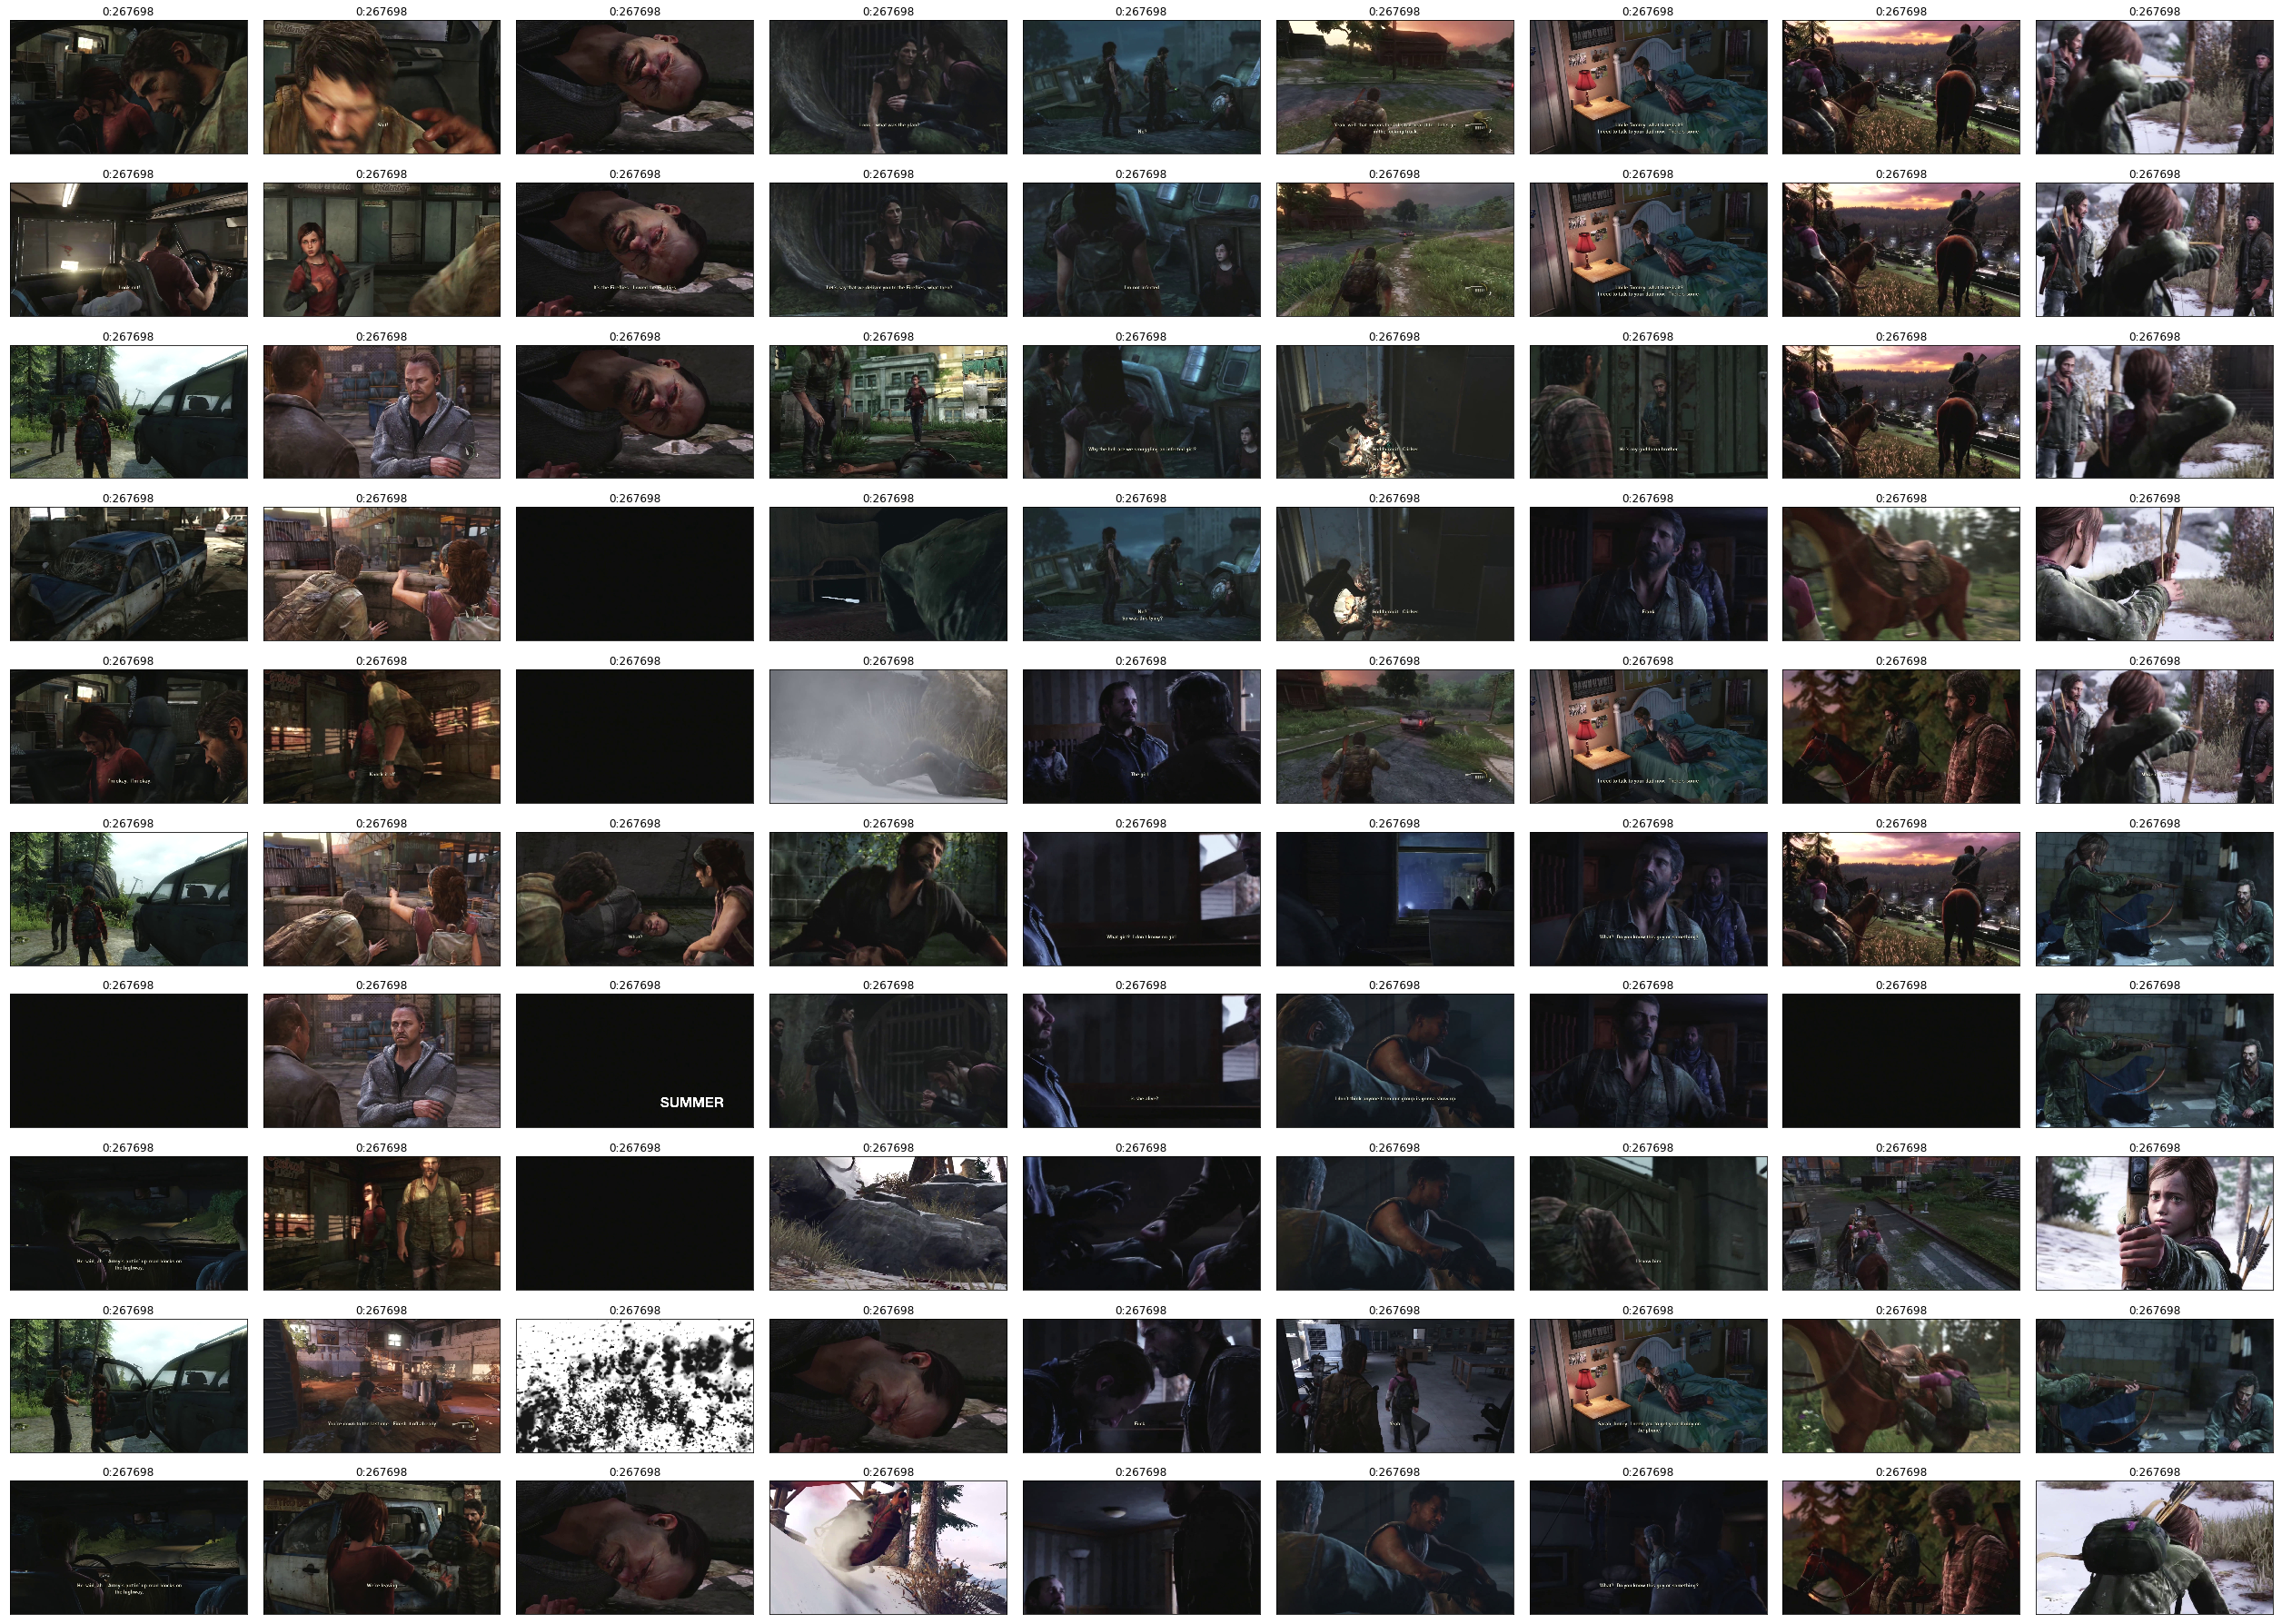

In [27]:
"""
Print out search results. 
To display only one result, just comment out line 7 and use line 6 instead, and 
replace that string with another inquiry listed in the answer file.
"""
#sentence_dir = ["Butterfly Bucket"]
sentence_dir = answer_database.keys()
top_n_neighbours = 10
if len(sentence_dir) > 1:
    fig, axes = plt.subplots(top_n_neighbours, len(sentence_dir), figsize=(35, 25), subplot_kw={'xticks': [], 'yticks': []})

for src_sentence_id, src_sentence in enumerate(sentence_dir):
    print(f'User Inquiry: {src_sentence}')
    for top_n, rst in enumerate(result_data[src_sentence][:top_n_neighbours]):
        distance = rst['distance']
        file_id = rst['file_id']
        session_id = rst['session_id']
        img_folder = database[file_id]['screenshots']['image_folder']
        img_sessions = database[file_id]['screenshots']['image_info']
        frame_id = rst['frame_id']
        img_file = img_sessions[session_id]['frames'][frame_id]['image_file']
        img_file = os.path.join(img_folder, img_file)
        image = Image.open(img_file) 
        cap_text = database[file_id]['captions']['captions'][session_id]['text']
        img_keywords = ''
        if 'image_keywords' in img_sessions[session_id]['frames'][frame_id].keys():
            img_keywords = img_sessions[session_id]['frames'][frame_id]['image_keywords']
        print(f'top_n: {top_n}, distance: {distance}, file_id: {file_id}, session_id: {session_id}, frame_id: {frame_id}, captions: {cap_text}, Image keywords: {img_keywords}')
        
        title = f'{file_id}:{key}'
        if len(sentence_dir) > 1:
            axes[top_n][src_sentence_id].imshow(np.asarray(image))
            axes[top_n][src_sentence_id].set_title(title)
        else:
            plt.figure()
            plt.imshow(image)
    
if len(sentence_dir) > 1:
    fig.tight_layout()       
    plt.show()